# Modeling and forecasting atmospheric CO₂ from 1958 until 2058

## Dealing with the data 

In [1]:
#import relevant libraries 
import pystan
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [2]:
#Lets look at our data 
#df1 = pd.read_csv(io.BytesIO(uploaded['weekly_in_situ_co2_mlo - weekly_in_situ_co2_mlo (1).csv']))
df1 = pd.read_csv('finaldata.csv')

df1.head()


,Date,C02
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [3]:
#convert to date time so we can work with
#the data in the way we wish to
df1['Date'] = pd.to_datetime(df1['Date'])

In [4]:
#Lets check if we are working with the correct data
#and plot from 2010 onwards 
#by trial and error I found the start point for 2010
df1.loc[2632:, ["Date"]]

,Date
2632,2010-01-02
2633,2010-01-09
2634,2010-01-16
2635,2010-01-23
2636,2010-01-30
...,...
3134,2019-08-31
3135,2019-09-07
3136,2019-09-14
3137,2019-09-21


/Users/bellabuchanan/anaconda3/envs/stan/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


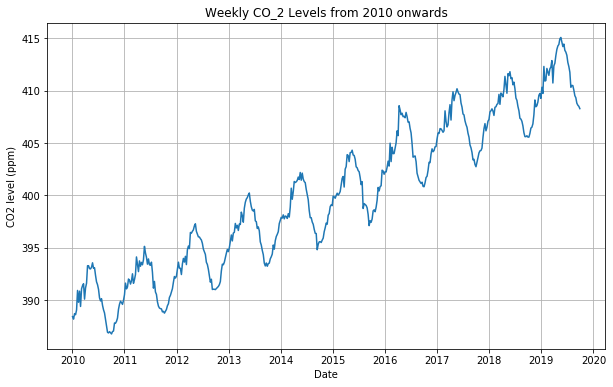

In [5]:
x = df1.loc[2632:, ["Date"]]
y = df1.loc[2632:, ["C02"]]

#Plotting figure from instructions 
fig1 = plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.grid()
plt.title('Weekly CO_2 Levels from 2010 onwards')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()
fig1.savefig('fig1.png')
#files.download('fig1.png')

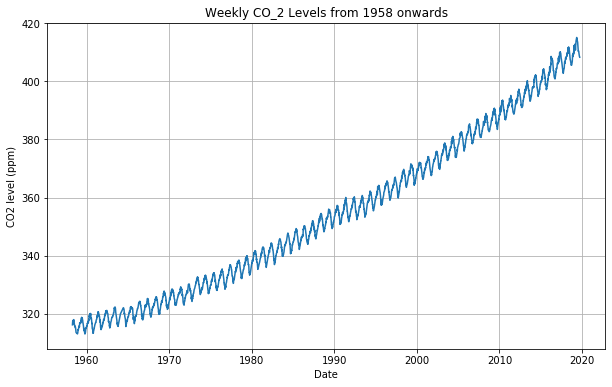

In [6]:
#Plotting all of the data like in the instructions
fig2 = plt.figure(figsize=(10,6))
plt.plot(df1.Date,df1.C02)
plt.grid()
plt.title('Weekly CO_2 Levels from 1958 onwards')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()
fig2.savefig('fig2.png')
#files.download('fig2.png')

In [7]:
#Since we are going to make a stan model
#we cannot input these date formats 
#we need numbers 
#so we are going to change the raw dates into numbers
#in the format of number of years since 1958
#because that was when the recording started 

print('Start date is:', df1.Date[0]) #our start date of recording 

print('2nd point - 1st point:',(df1.Date[1] - df1.Date[0]).days) #so we can to get days we subtract two entries

print('Convert to years:',(df1.Date[1] - df1.Date[0]).days / 365.25) #divide to get years

Start date is: 1958-03-29 00:00:00
2nd point - 1st point: 7
Convert to years: 0.019164955509924708


In [8]:
#ok now that we tested for 1 point, lets convert
#all of the data to years since we started

df1['years_since'] = [(df1.Date[i] - df1.Date[0]).days / 365.25 for i in range(len(df1.Date))]

In [9]:
#Lets check it worked
df1.head()

,Date,C02,years_since
0,1958-03-29,316.19,0.000000
1,1958-04-05,317.31,0.019165
2,1958-04-12,317.69,0.038330
3,1958-04-19,317.58,0.057495
4,1958-04-26,316.48,0.076660


In [10]:
df1.tail() #looks good 

,Date,C02,years_since
3134,2019-08-31,409.32,61.423682
3135,2019-09-07,408.80,61.442847
3136,2019-09-14,408.61,61.462012
3137,2019-09-21,408.50,61.481177
3138,2019-09-28,408.28,61.500342


https://spacemath.gsfc.nasa.gov/earth/6Page54.pdf

## The Model

The model needs to demonstrate:
- The visible trend over time
- Seasonality: CO2 absorbtion by plants is higher in spring and summer when they grow, and lower in winters when humans use more fossil fuels to stay warm
- Noise: random fluctuations in the curve 

To criticise the example model given, I would like to implement it, and then decide what areas need improvement. 

The example model is:
*   Long-term trend: linear, $c_0 + c_1t$
*   Seasonal variation (every 365¼ days): cosine, $c_2cos(2πt/365.25+c_3)$
*   Noise: Gaussian with 0 mean and fixed standard deviation, $c_4$
*    The $c_i$ variables are all unobserved parameters of the model.

At an initial glance, I suspect the long term trend is not linear, but rather quadratic because there seems to be a slights curve to the data. There appears to be more noise than smooth curve, so the noise parameter may not be normally centered around zero.

Let us implement this model:


## Trend of the model

Looking at the data, I suspect that the trend is not generally linear. Having some background in CO2 levels, I know the concept of the Keeling curve (which is basically the figures produced above) that models the accumulation of CO2 in the atmosphere. The Keeling curve is better estimated by a low order polynomial, such as a quadratic which is of degree 2 ([cite](https://medium.com/@plotnick/goodbye-400-ppm-the-statistics-of-the-keeling-curve-5a79586d1b2e)). But, let's not assume this is correct. Let us compare the linear and quadratic fit, and then decide which is better 

### Linear trend

We are now trying to estimate the line that would model this data, should it have a linear trend. Linear trends come in the form of:

$y = mx + b$ 

We will have to decide upon priors for $m$ and $b$ as well as the variance used to estimate $CO_2$ (ppm) levels:


*   Slope, $m$: $N(0.8,1.5)$ since I think $CO_2$ levels are increasing, but I want higher uncertainty because I am worried that I could be biased and want to reflect this uncertainty. I choose a normal distribution so that most of my estimates will be centered around 0.8 to reflect my prior knowledge.
*   Y-cut, $b$: $N(300,15)$. This seems reasonable looking at our data (I know this is not really what we are meant to do, but since I this is the only prior intuition I have, I give a variance of 15)
*   Variance, $vari$: $Cauchy(10,5)$: I want to allow smaller and bigger fluctuations, and thick tails so a larger portion are not 10, as would be in the normal distribution that has thin tails.



In [11]:
#Put our data in a dictionary in 
#the correct format so that we can
#parse it through our stan model 
stan_data = {
    "len_data" : len(df1),
    "time" : df1.years_since.values,
    "ppm" : df1.C02.values,
}

In [12]:
linear_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> time[len_data];      // time since beginning of study
    real ppm[len_data];               // ppm data
}

parameters {
    real<lower=0> b;  // y cut
    real<lower=0> m;  // gradient
    real<lower=0> vari;        // noise parameter in normal
} 

model {
 
    // Priors
    b ~ normal(300, 15);
    m ~ normal(0.8,1.5);
    vari ~ cauchy(10,5);

    for (i in 1:len_data) {
        ppm[i] ~ normal(m*time[i]+b, vari); 
    }
}

"""
linear = pystan.StanModel(model_code=linear_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_530f08d4be01c4bb71a10ddc9d420154 NOW.


In [13]:
#Extract our results through sampling 
linear_results = linear.sampling(data=stan_data)
linear_samples = linear_results.extract()
linear_line = linear_samples['b'].mean() + linear_samples['m'].mean()*df1.years_since.values


## Quadratic trend 

Let's model the trend of the data using a quadratic trend. A quadratric trend comes in the form:

$ax^2+bx+c$

Priors:


*   Y cut; $c$: once again we will set $N(300,30)$ as our prior for the y cut
*   $a$: After playing around with graphing tools, it seems reasonable for $a$ to be N(1,1) so it is usually a low positive number which gives a similar shape to what we know to be the Keeling curve
*   $b$: I am quite unsure about what $b$ should be so I chose $N(0,10)$ so the horizontal shift of the line can be positive and negative with high levels of uncertainty
*   We use the same prior for variance for the same reasons 




In [14]:
quadratic_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> time[len_data];      // time since beginning of study
    real ppm[len_data];               // ppm data
}

parameters {
    real<lower=0> c;  // y cut
    real<lower=0> a;  // ax^2
    real<lower=0> b;  // bx
    real<lower=0> vari;        // noise parameter in normal
} 

model {
 
    // Priors
    c ~ normal(300, 30);
    a ~ normal(1,1);
    b ~ normal(0,5);
    vari ~ cauchy(10,5);

    for (i in 1:len_data) {
        ppm[i] ~ normal(a*time[i]^2+b*time[i]+c, vari); 
    }
}

"""
quadratic = pystan.StanModel(model_code=quadratic_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_db2e305bfaf06697b996375c692d675e NOW.


In [15]:
#Extract our results through sampling 
quadratic_results = quadratic.sampling(data=stan_data)
quadratic_samples = quadratic_results.extract()


In [16]:
quadratic_line = quadratic_samples['c'].mean() + quadratic_samples['b'].mean()*df1.years_since.values + quadratic_samples['a'].mean()*df1.years_since.values**2


### Quadratic vs Linear Comparison 

From the plots below, it seems my intuition to use a quadratic trend over a linear trend was good. So, for our final model we will use a quadratic trend.

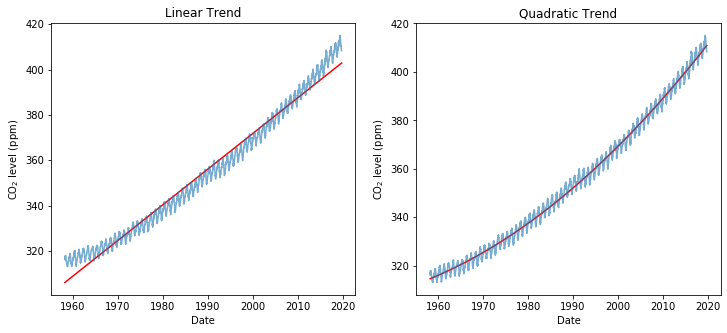

In [17]:
fig3 = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(df1.Date, linear_line, color="red")
plt.plot(df1.Date, df1.C02, alpha = 0.6)
plt.title('Linear Trend')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')

plt.subplot(1, 2, 2)
plt.plot(df1.Date, quadratic_line, color="red")
plt.plot(df1.Date, df1.C02, alpha = 0.6)
plt.title('Quadratic Trend')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')
plt.show()
fig3.savefig('fig3.png')
#files.download('fig3.png')

## Seasonal component

To be able to model the seasonal component of the data we need to remove the upwards trend from the data. 

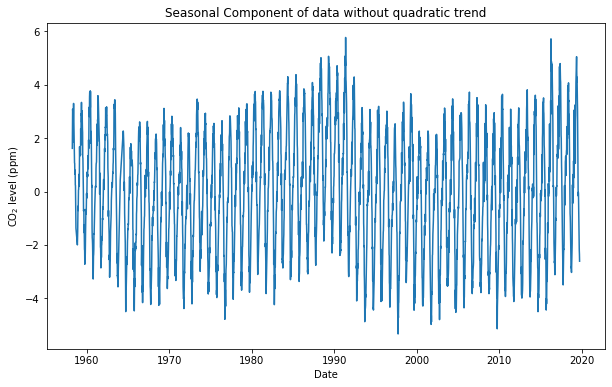

In [18]:
seasonal = df1.C02 - quadratic_line
df1['Seasonal'] = df1.C02 - quadratic_line

fig4 = plt.figure(figsize=(10,6)) 
plt.plot(df1.Date,seasonal)
plt.title('Seasonal Component of data without quadratic trend')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')
plt.show()
fig4.savefig('fig4.png')
#files.download('fig4.png')

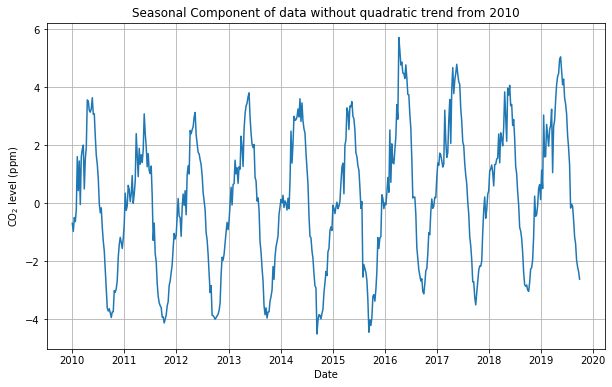

In [19]:
fig5 = plt.figure(figsize=(10,6))
plt.plot(df1.loc[2632:, ["Date"]],seasonal[2632:])
plt.title('Seasonal Component of data without quadratic trend from 2010')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')
plt.grid()
plt.show()
fig5.savefig('fig5.png')
#files.download('fig5.png')

We want to model this seasonal compenent. The original model suggested that it was: $c_2cos(2πt/365.25+c_3)$

I am not sure how accurate this is, but it seems reasonable to model seasonality with a trigonometric function, with a period of a year, since that is the timeframe that the seasons work around. I also assume the sine curve could work, so lets try both of those and see which one is better to model seasonality.

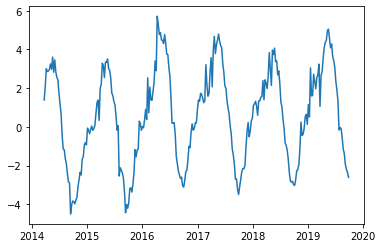

In [20]:
#subset data to play around with seasonal models
df2 = df1[2850:]
len(df2)
plt.plot(df2.Date, df2.Seasonal)

In [21]:
seasonal_data = {
    "len_data" : len(df2),
    "time" : df2.years_since.values,
    "ppm" : df2.Seasonal.values,
    "two_pi" : 2*np.pi
}

In [22]:
cos_seasonal_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> time[len_data];      // time since beginning of study
    real ppm[len_data];               // ppm data
    real<lower=0> two_pi;
    
}

parameters {
    real<lower=0> c2;  
    real<lower=0> vari;        // noise parameter in normal

    // We need a periodic phi
    real periodic_x;
    real periodic_y;

} 

transformed parameters {
    real phi = atan2(periodic_x,periodic_y) ;
}

model {
 
    // Priors
    periodic_x ~ normal(0,0.5);
    periodic_y ~ normal(0,0.5);
    c2 ~ inv_gamma(6, 1);
    vari ~ cauchy(0,2);

    for (i in 1:len_data) {
        ppm[i] ~ normal(c2*cos(two_pi*time[i]+phi), vari); 
    }
}

"""
cos_seasonal_model = pystan.StanModel(model_code=cos_seasonal_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_217a79764a7f114886c66a42dd5f5531 NOW.


In [23]:
cos_seasonal_results = cos_seasonal_model.sampling(data=seasonal_data)

In [24]:
cos_seasonal_results

Inference for Stan model: anon_model_217a79764a7f114886c66a42dd5f5531.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2           3.14  3.2e-3    0.1   2.94   3.07   3.14    3.2   3.33    973   1.01
vari         1.16  1.2e-3   0.05   1.07   1.13   1.16   1.19   1.26   1439    1.0
periodic_x  -0.22  5.1e-3   0.11  -0.48  -0.29  -0.21  -0.14  -0.06    483   1.01
periodic_y   0.59    0.01   0.29   0.16   0.37   0.55   0.77   1.23    465   1.01
phi         -0.36  5.8e-4   0.03  -0.42  -0.38  -0.36  -0.34   -0.3   2788    1.0
lp__       -196.2    0.05   1.53 -200.2 -197.1 -195.9 -195.1 -194.2   1006    1.0

Samples were drawn using NUTS at Wed Dec 18 12:02:49 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [25]:
#Extract our results through sampling 
cos_seasonal_samples = cos_seasonal_results.extract()


In [26]:
cos_seasonal_line = cos_seasonal_samples['c2'].mean()*np.cos(2*np.pi*df2.years_since.values+cos_seasonal_samples['phi'].mean())
len(cos_seasonal_line)

289

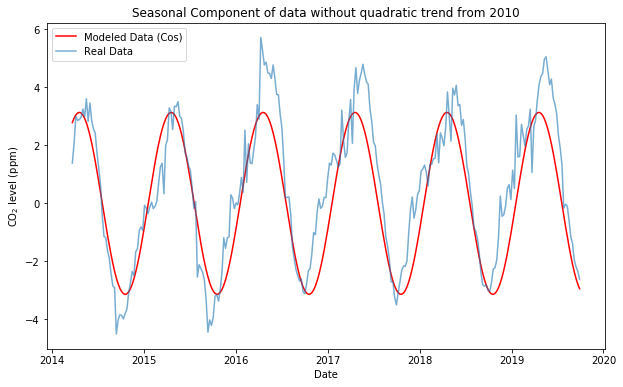

In [27]:
fig6 = plt.figure(figsize=(10,6))

plt.plot(df2.Date,cos_seasonal_line,color="red",label="Modeled Data (Cos)")
plt.plot(df2.Date,seasonal[2850:],alpha=0.6,label="Real Data")
plt.title('Seasonal Component of data without quadratic trend from 2010')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')
plt.legend(loc="upper left")
fig6.savefig('fig6.png')
#files.download('fig6.png')


In [28]:
#NEWWWWW
sin_seasonal_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> time[len_data];      // time since beginning of study
    real ppm[len_data];               // ppm data
    real<lower=0> two_pi;
    
}

parameters {
    real<lower=0> c2;  
    real<lower=0> c3;  
    real<lower=0> vari;        // noise parameter in normal

    // We need a periodic phi
    real periodic_x;
    real periodic_y;

} 

transformed parameters {
    real phi = atan2(periodic_x,periodic_y) ;
}

model {
 
    // Priors
    periodic_x ~ normal(0,1);
    periodic_y ~ normal(0,1);
    c2 ~ inv_gamma(6, 1);
    c3 ~ normal(0.5, 0.1);
    vari ~ cauchy(0,2);

    for (i in 1:len_data) {
        ppm[i] ~ normal(c2*sin(two_pi*time[i]-c3*sin(two_pi*time[i])+phi), vari); 
    }
}

"""
sin_seasonal_model = pystan.StanModel(model_code=sin_seasonal_stan_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ef49d65be1141598810ecf15a8d4aac0 NOW.


In [29]:
#NEWWW
sin_seasonal_results = sin_seasonal_model.sampling(data=seasonal_data)

In [30]:
sin_seasonal_results

Inference for Stan model: anon_model_ef49d65be1141598810ecf15a8d4aac0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2           3.19  2.8e-3   0.08   3.03   3.13   3.19   3.24   3.33    724   1.01
c3           0.37  1.1e-3   0.03   0.32   0.35   0.37   0.39   0.43    682   1.01
vari         0.96  2.5e-3   0.04   0.89   0.93   0.96   0.99   1.04    257   1.02
periodic_x    1.2    0.07   0.63   0.25   0.72   1.11    1.6   2.62     82   1.04
periodic_y   0.36    0.02   0.19   0.07   0.21   0.33   0.47   0.79     84   1.04
phi          1.28  6.2e-4   0.03   1.23   1.26   1.28    1.3   1.33   1646    1.0
lp__       -141.2    0.12   1.75 -145.6 -142.2 -140.8 -139.9 -138.9    215   1.02

Samples were drawn using NUTS at Wed Dec 18 12:03:36 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potentia

In [31]:
#Extract our results through sampling 
sin_seasonal_samples = sin_seasonal_results.extract()


In [32]:
sin_seasonal_line = sin_seasonal_samples['c2'].mean()*np.sin(2*np.pi*df2.years_since.values- \
                                                             sin_seasonal_samples['c3'].mean()*np.sin(2*np.pi*df2.years_since.values) + \
                                                             sin_seasonal_samples['phi'].mean())




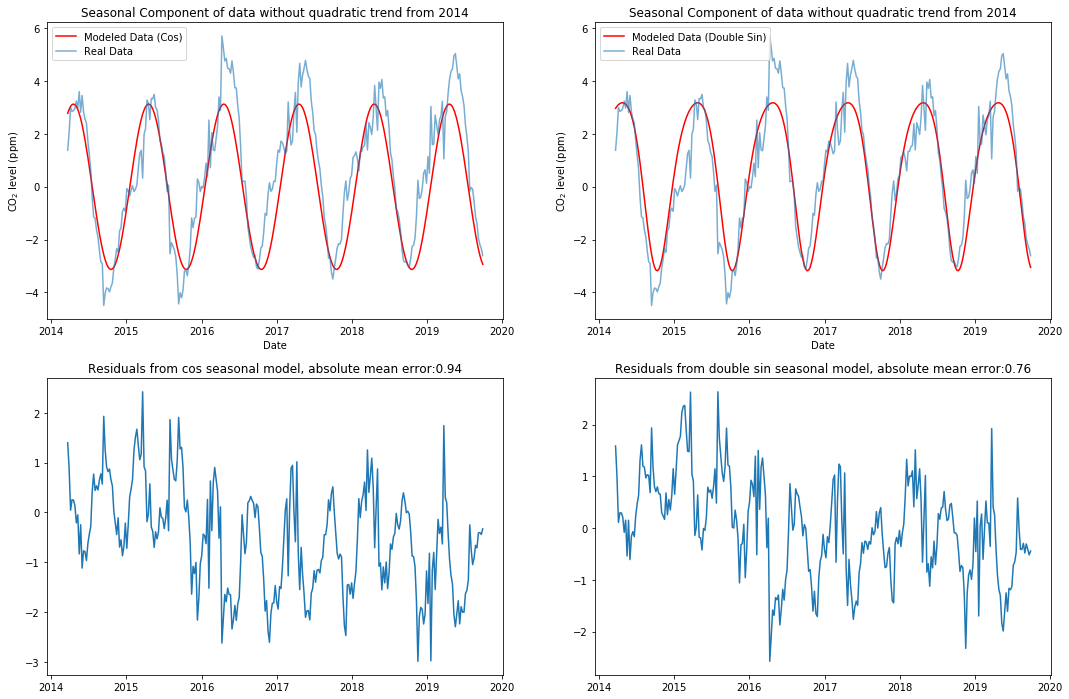

In [33]:
fig_seas = plt.figure(figsize=(18,12))

#cos
plt.subplot(2, 2, 1)
plt.plot(df2.Date,cos_seasonal_line,color="red",label="Modeled Data (Cos)")
plt.plot(df2.Date,seasonal[2850:],alpha=0.6,label="Real Data")
plt.title('Seasonal Component of data without quadratic trend from 2014')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')
plt.legend(loc="upper left")


#sin
plt.subplot(2, 2, 2)
plt.plot(df2.Date,sin_seasonal_line,color="red",label="Modeled Data (Double Sin)")
plt.plot(df2.Date,seasonal[2850:],alpha=0.6,label="Real Data")
plt.title('Seasonal Component of data without quadratic trend from 2014')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')
plt.legend(loc="upper left")

#cos error 
plt.subplot(2, 2, 3)
error_cos = cos_seasonal_line - seasonal[2850:]
plt.plot(df2.Date,error_cos)
plt.title('Residuals from cos seasonal model, absolute mean error:'+str(round(sum(abs(error_cos))/len(error_cos),2)))

#sin error
plt.subplot(2, 2, 4)
error_sin1 = sin_seasonal_line - seasonal[2850:]
plt.plot(df2.Date,error_sin1)
plt.title('Residuals from double sin seasonal model, absolute mean error:' +str(round(sum(abs(error_sin1))/len(error_sin1),2)))
fig_seas.savefig('fig_seas.png')


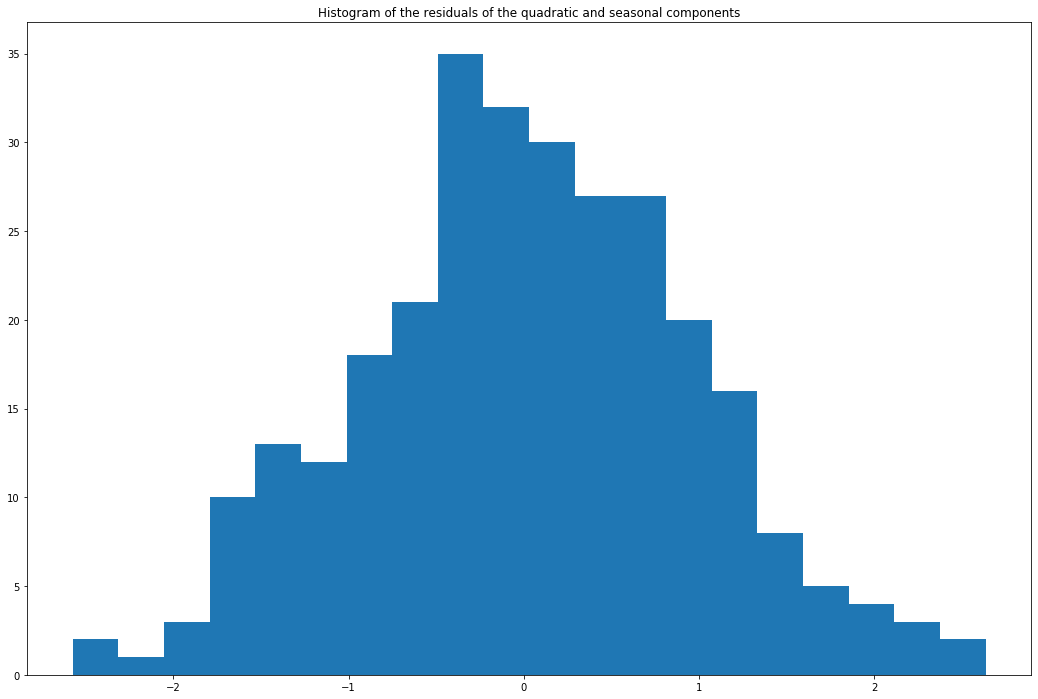

In [83]:
fig_res = plt.figure(figsize=(18,12))
plt.hist(error_sin1,bins =20)
plt.title('Histogram of the residuals of the quadratic and seasonal components')

fig_res.savefig('fig_res.png')

In [35]:
prediction_dates = pd.date_range("2019-10-05", "2058-03-29", freq='W-FRI')
prediction_times = (prediction_dates - df1.Date[0]).days / 365.25 

In [36]:
stan_data = {
    "len_data" : len(df1),
    "time" : df1.years_since.values,
    "ppm" : df1.C02,
    "two_pi" : 2*np.pi,
    "n_future" : len(prediction_times),
    "future_time" : prediction_times
}

In [37]:
#the dates we need to predict for
prediction_dates = pd.date_range("2019-10-05", "2058-03-29", freq='W-FRI')
prediction_times = (prediction_dates - df1.Date[0]).days / 365.25 
prediction_times

Float64Index([ 61.53593429158111, 61.555099247091036,  61.57426420260096,
               61.59342915811088,  61.61259411362081,  61.63175906913073,
               61.65092402464066,  61.67008898015058,  61.68925393566051,
               61.70841889117043,
              ...
               99.82751540041068,   99.8466803559206,  99.86584531143053,
               99.88501026694045,  99.90417522245038,   99.9233401779603,
               99.94250513347022,  99.96167008898016,  99.98083504449008,
                           100.0],
             dtype='float64', length=2008)

In [84]:
# some time.

stan_code = """
data {

    int<lower=0> len_data;             // length of data
    real<lower=0> time[len_data];      // time since beginning of study
    real ppm[len_data];               // ppm data
    real<lower=0> two_pi;

    int<lower=0> n_future; // The number of future values to predict
    real<lower=0> future_time[n_future];
    
}

parameters {

  
    real<lower=0> c;  // y cut
    real<lower=0> a;  // ax^2
    real<lower=0> b;  // bx
    real vari;        // noise parameter in normal

    real<lower=0> c2;  
    real<lower=0> c3;  

    // We need a periodic phi
    real periodic_x;
    real periodic_y;
}

transformed parameters {
    
    real phi = atan2(periodic_x,periodic_y) ;
}

model {
    
    // Priors
    periodic_x ~ normal(0,1);
    periodic_y ~ normal(0,1);
    c ~ normal(300, 30);
    a ~ normal(1,1);
    b ~ normal(0,5);
    c2 ~ normal(6, 1);
    c3 ~ normal(0.5, 0.1);
    vari ~ cauchy(0,0.5);

    for (i in 1:len_data) {
        ppm[i] ~ normal(a*time[i]^2+b*time[i]+c+c2*sin(two_pi*time[i]-c3*sin(two_pi*time[i])+phi), vari);

    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(i in 1:n_future) {
        x_future[i] = normal_rng(
            a*future_time[i]^2+b*future_time[i]+c+c2*sin(two_pi*future_time[i]-c3*sin(two_pi*future_time[i])+phi), vari
            );
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e62230f754be540e7d76522c226cf2f8 NOW.


In [85]:
stan_data = {
    "len_data" : len(df1),
    "time" : df1.years_since.values,
    "ppm" : df1.C02,
    "two_pi" : 2*np.pi,
    "n_future" : len(prediction_times),
    "future_time" : prediction_times
}

In [86]:
stan_results = stan_model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [87]:
stan_results


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_e62230f754be540e7d76522c226cf2f8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c             314.1  1.3e-3   0.06 313.99 314.06 314.09 314.13 314.21   1932    1.0
a              0.01  1.5e-6 6.0e-5   0.01   0.01   0.01   0.01   0.01   1526    1.0
b              0.77  9.8e-5 3.9e-3   0.76   0.77   0.77   0.77   0.78   1571    1.0
vari           0.92  2.2e-4   0.01    0.9   0.91   0.92   0.93   0.94   2691    1.0
c2             2.92  4.6e-4   0.02   2.88   2.91   2.92   2.94   2.97   2689    1.0
c3             0.35  3.1e-4   0.02   0.32   0.34   0.35   0.36   0.38   2550    1.0
periodic_x     1.19    0.02   0.57   0.35   0.75   1.11   1.53    2.5    850   1.01
periodic_y     0.49  7.9e-3   0.23   0.14    0.3   0.45   0.63   1.03    858   1.01
phi            

In [88]:
samples = stan_results.extract()

In [89]:
b = samples['b'].mean()
c = samples['c'].mean()
a = samples['a'].mean()
c2 = samples['c2'].mean()
c3 = samples['c3'].mean()
phi = samples['phi'].mean()

In [90]:
line = c +b*df2.years_since.values + a*df2.years_since.values**2 + \
c2*np.sin(2*np.pi*df2.years_since.values- \
              c3*np.sin(2*np.pi*df2.years_since.values) + \
               phi)

In [108]:
line1 = c +b*df1.years_since.values + a*df1.years_since.values**2 + \
c2*np.sin(2*np.pi*df1.years_since.values- \
              c3*np.sin(2*np.pi*df1.years_since.values) + \
               phi)

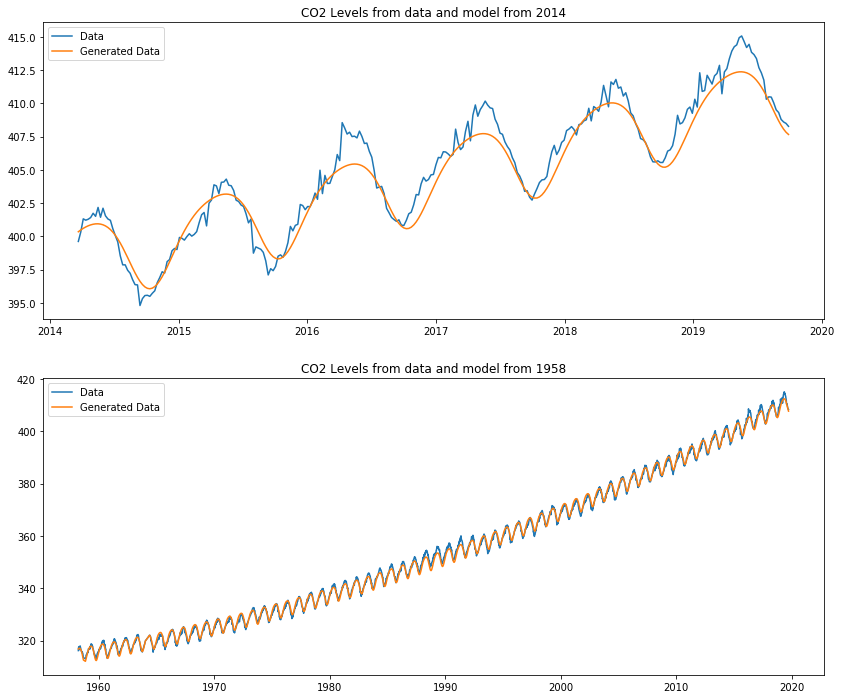

In [120]:
#plot the generated data 
fig_d = plt.figure(figsize=(14,12))

#cos
plt.subplot(2, 1, 1)
plt.title('CO2 Levels from data and model from 2014')
plt.plot(df2.Date,df2.C02, label = 'Data')
plt.plot(df2.Date,line,label = 'Generated Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('CO2 Levels from data and model from 1958')
plt.plot(df1.Date,df1.C02, label = 'Data')
plt.plot(df1.Date,line1,label = 'Generated Data')
plt.legend()

fig_seas.savefig('fig_d.png')


In [91]:
#get the mean predictions from our samples
predictions = []
for i in range(2008):
  sum1 = 0
  for j in range(1000):
    sum1+= samples['x_future'][j][i]
  predictions.append(sum1/1000)

In [92]:
#get the mean predictions from our samples
lower = []
upper = []
for i in range(2008):
  store = []
  for j in range(1000):
    store.append(samples['x_future'][j][i])
  lower.append(np.percentile(store, 2.5))
  upper.append(np.percentile(store, 97.5))

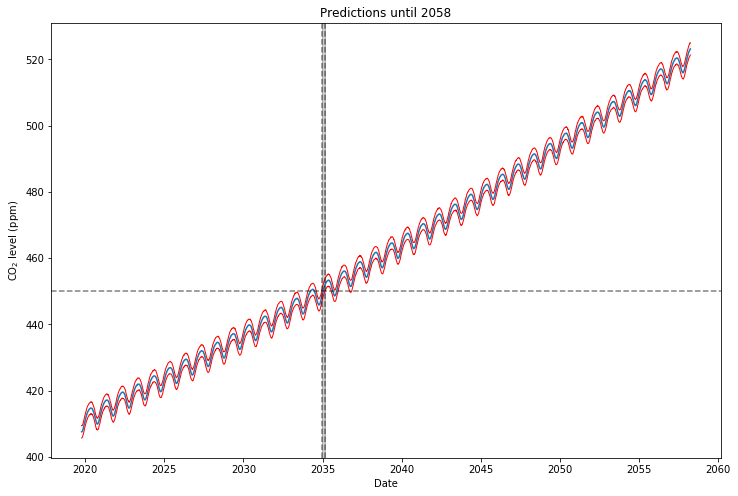

In [131]:
#plot 95% confidence intervals 
figpred = plt.figure(figsize=(12,8))
#plt.plot(df2.Date,line,color="red",label="Modeled Data (Sin)")
#plt.plot(df2.Date,df2.C02,alpha=0.6,label="Real Data")
#plt.plot(df1.Date,df1.C02,alpha=0.6,label="Real Data")
plt.plot(prediction_dates,predictions)
plt.plot(prediction_dates,lower, color = 'red',linewidth = 1)
plt.plot(prediction_dates,upper, color = 'red',linewidth = 1)
plt.axhline(450, color = 'black',alpha=0.5,ls='dashed')
plt.axvline(prediction_dates[792], color = 'black',alpha=0.5,ls='dashed')
plt.axvline(prediction_dates[802], color = 'black',alpha=0.5,ls='dashed')
plt.axvspan(prediction_dates[792], prediction_dates[802], color='black', alpha=0.2)


plt.title('Predictions until 2058')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')
figpred.savefig('figpred.png')


In [94]:
print('The predicted date to reach 450 ppm is:',prediction_dates[796], 'with a 95% confidence interval between',prediction_dates[792],'and',prediction_dates[802])




The predicted date to reach 450 ppm is: 2035-01-12 00:00:00 with a 95% confidence interval between 2034-12-15 00:00:00 and 2035-02-23 00:00:00


In [95]:
#our parameters
parameters = ['a', 'b','c','c2','c3','phi','vari']


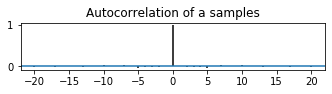

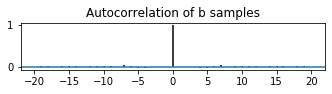

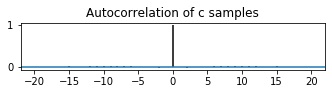

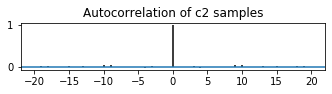

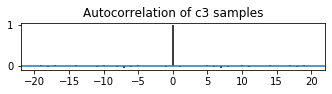

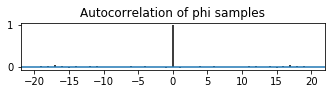

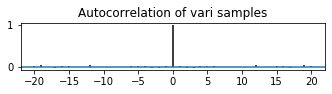

In [129]:

# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

count = 1
for param in parameters:
    p=plt.figure(figsize=(12, 4))
    plt.subplot(4, 2, count)
    count+=1
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')


plt.show()
p.savefig('p.png')

<Figure size 432x288 with 0 Axes>

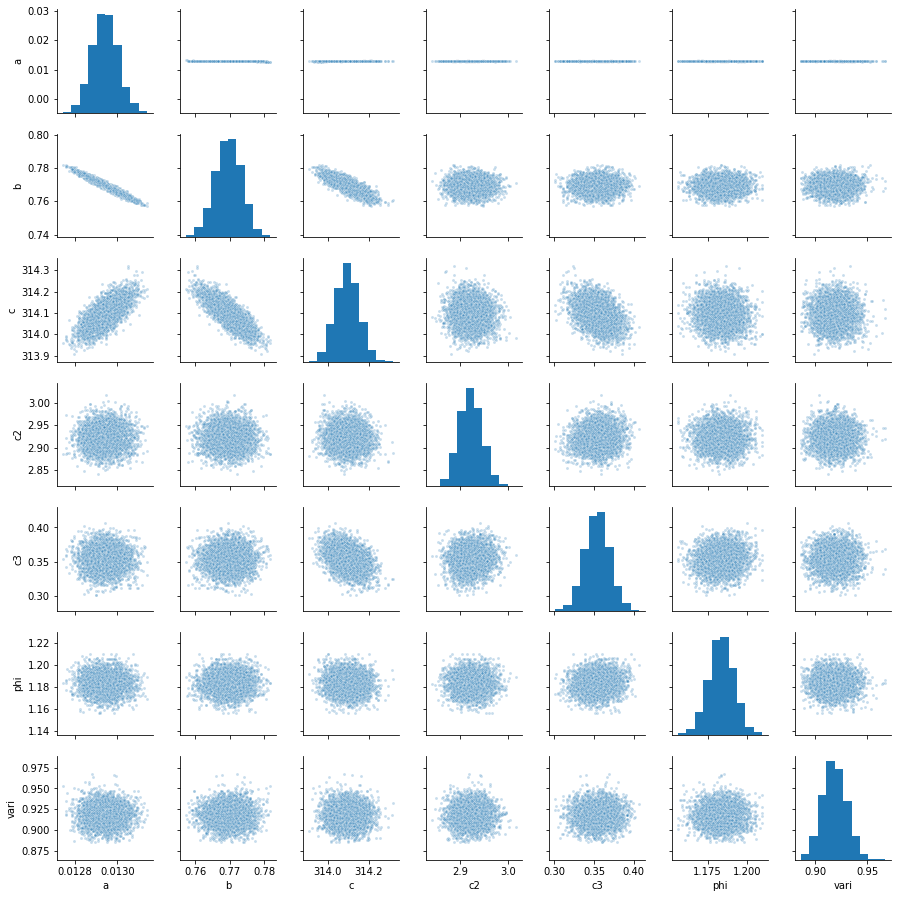

In [130]:
# Make pair plot of the posteriors over all parameters of the model.
pp = plt.figure()
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=1.8, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()
pp.savefig('pp.png')

In [52]:
len(samples)

11

In [98]:
#extract 4000 samples from our posterior parameters
store = [ [] for i in range(4000) ]
def create_samples(store, samples):
    
    for i in range(4000):
        
        for t in df1['years_since']:
            store[i].append(sts.norm.rvs(samples['a'][i]*t**2 + samples['b'][i]*t + samples['c'][i] + \
                                 samples['c2'][i]*np.sin(2*np.pi*t -samples['c3'][i]*np.sin(2*np.pi*t) + samples['phi'][i])  \
                                 , samples['vari'][i]))
    return store
        
    

In [99]:
generated_samples = create_samples(store, samples)

In [55]:
len(generated_samples[0])==len(df1.Date)

True

In [100]:
#P VALUE STATISTICS
#2.5 percentile
lower_stats = []
count = 0
for i in range(len(generated_samples)):
  lower_stats.append(np.percentile(generated_samples[i], 5))
  if np.percentile(generated_samples[i], 5) > np.percentile(df1.C02,5):
    count += 1
lower_p= count/len(generated_samples)
 
#97.5 percentile
upper_stats = []
count = 0
for i in range(len(generated_samples)):
    upper_stats.append(np.percentile(generated_samples[i], 95))
    if np.percentile(generated_samples[i], 95) > np.percentile(df1.C02,95):
        count += 1
upper_p= count/len(generated_samples)
 
#mean
mean_stats = []
count = 0
for i in range(len(generated_samples)):
  mean_stats.append(np.mean(generated_samples[i]))
  if np.mean(generated_samples[i]) > np.mean(df1.C02):
    count += 1
mean_p= count/len(generated_samples)
 
#standard deviation
sd_stats = []
count = 0
for i in range(len(generated_samples)):
  sd_stats.append(np.std(generated_samples[i]))
  if np.std(generated_samples[i]) > np.std(df1.C02):
    count += 1
sd_p= count/len(generated_samples)
 
#range
range_stats = []
count = 0
for i in range(len(generated_samples)):
  range_stats.append(np.max(generated_samples[i])-np.min(generated_samples[i]))
  if np.max(generated_samples[i])-np.min(generated_samples[i]) > np.max(df1.C02)-np.min(df1.C02):
    count += 1
range_p= count/len(generated_samples)

#median
med_stats = []
count = 0
for i in range(len(generated_samples)):
  med_stats.append((np.mean(generated_samples[i])+np.std(generated_samples[i]))-(np.mean(generated_samples[i])-np.std(generated_samples[i])))
  if med_stats[i] > (np.mean(df1.C02)+np.std(df1.C02))-(np.mean(df1.C02)-np.std(df1.C02)):
    count += 1
med_p= count/len(generated_samples)
 


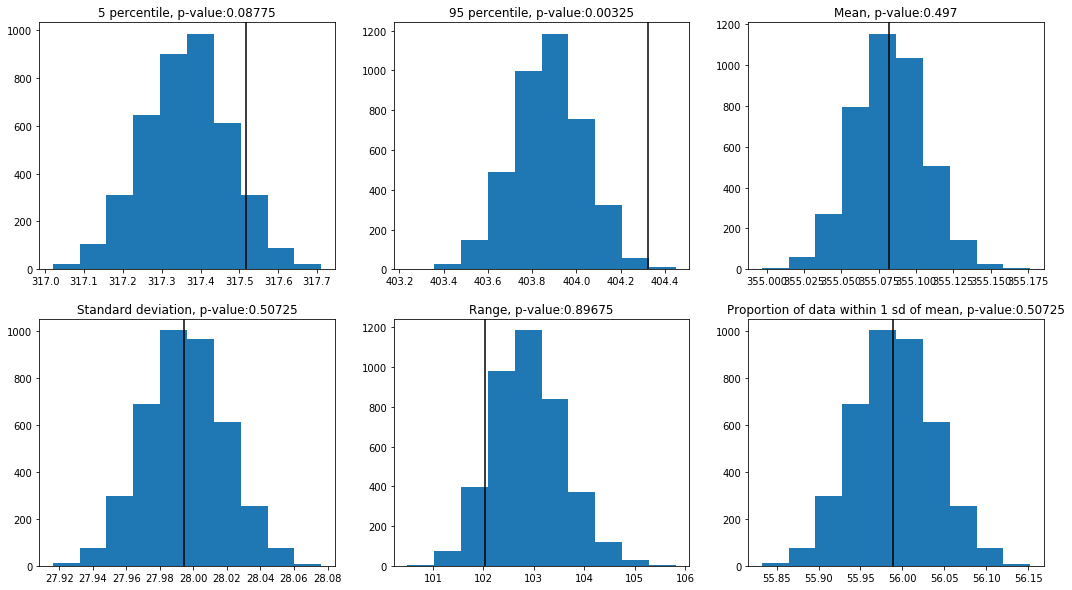

In [121]:
fig10 = plt.figure(figsize=(18,10))
plt.subplot(2, 3, 1)
plt.hist(lower_stats)
plt.title('5 percentile, p-value:'+ str(lower_p))
plt.axvline(np.percentile(df1.C02,5), color='black') 

plt.subplot(2, 3, 2)
plt.hist(upper_stats)
plt.title('95 percentile, p-value:'+str(upper_p))
plt.axvline(np.percentile(df1.C02,95), color='black')

plt.subplot(2, 3, 3)
plt.hist(mean_stats)
plt.title('Mean, p-value:'+str(mean_p))
plt.axvline(np.mean(df1.C02), color='black')

plt.subplot(2, 3, 4)
plt.hist(sd_stats)
plt.title('Standard deviation, p-value:'+str(sd_p))
plt.axvline(np.std(df1.C02), color='black')

plt.subplot(2, 3, 5)
plt.hist(range_stats)
plt.title('Range, p-value:'+str(range_p))
plt.axvline(np.max(df1.C02)-np.min(df1.C02), color='black')

plt.subplot(2, 3, 6)
plt.hist(med_stats)
plt.title('Proportion of data within 1 sd of mean, p-value:'+str(med_p))
plt.axvline((np.mean(df1.C02)+np.std(df1.C02))-(np.mean(df1.C02)-np.std(df1.C02)), color='black')
fig10.savefig('fig10.png')